In [2]:
# Imports
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal, TypedDict, Annotated, Dict
import operator
import os

print("✅ All imports successful")

✅ All imports successful


In [3]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found!")

print("✅ API key loaded")

✅ API key loaded


In [4]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7,
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


In [12]:
# Tools for collaborative agents

@tool
def generate_ideas(topic: str) -> str:
    """Generates 3-5 key points about a topic."""
    # Simulated output
    return f"""Key Ideas for {topic}: 
1. Mental Health,
2. Innovation.
3. Income generation.
"""

@tool
def draft_content(ideas: str) -> str:
    """Transforms provided ideas into a structured draft."""
    return f"""BLOG DRAFT:
Intro: Welcome to the world of {ideas}...
Body: Detailed analysis...
Conclusion: Final thoughts."""

@tool
def validate_claims(draft: str) -> str:
    """
    Check the draft for factual accuracy and valid claims.
    Ensures that the content aligns with known data before publishing.
    """
    print("🔍 [TOOL]: Fact-checking the draft...")
    
    # Logic to simulate verification
    if "Income generation" in draft:
        return "✅ Fact Check Passed: Claims about income generation are supported by current economic trends."
    
    if "Mental Health" in draft and "Intro" not in draft:
         return "⚠️ Fact Check Warning: Mental health claims require a formal introduction for context."

    return "✅ Fact Check Passed: Content appears to be general knowledge."

@tool
def improve_writing(draft: str) -> str:
    """Polishes content for better flow and clarity."""
    return f"""POLISHED VERSION:
Draft: {draft.replace('BLOG DRAFT:', 'OFFICIAL POST:')}
(Edited for clarity and tone.)"""



In [13]:
# Collaborative State
class PipelineState(TypedDict):
    """State for collaborative agents."""
    messages: Annotated[list, operator.add]  # Conversation history
    topic: str
    ideas: str
    draft: str
    fact_check_notes: str
    final_output: str



In [24]:
# Node 1: Brainstormer
brainstomer_prompt = SystemMessage(content="""You are a conceptualist.
Use the generate_ideas tool to outline key points.
""")
brain_llm =llm.bind_tools([generate_ideas])

def brainstormer_node(state: PipelineState):
    topic = state["topic"]
    messages = [
        brainstomer_prompt,
        HumanMessage(content=f"Generate ideas for: {topic}")
    ]
    response = brain_llm.invoke(messages)
    
    ideas_output = ""
    if response.tool_calls:
        tool_call = response.tool_calls[0]
        ideas_output = generate_ideas.invoke(tool_call["args"])
        print(f"   {ideas_output}\n")
    else:
        ideas_output = response.content
        print(f"\n🔍 Ideas output: {ideas_output[:50]}...\n")
        
    return {
        "messages": [AIMessage(content=f"Brainstormer: {ideas_output}")],
        "ideas": ideas_output
    }

# Node 2: Writer
writer_prompt = SystemMessage(content="""You are a technical writer.
Use the draft_content tool to write a post based on ideas.""")
writer_llm = llm.bind_tools([draft_content])

def writer_node(state: PipelineState):
    ideas = state["ideas"]
    messages = [
        writer_prompt,
        HumanMessage(content=f"Write a draft based on these ideas provided: {ideas}")
    ]
    response = writer_llm.invoke(messages)
    
    draft_output = ""
    if response.tool_calls:
        tool_call = response.tool_calls[0]
        draft_output = draft_content.invoke(tool_call["args"])
        print(f"   {draft_output}\n")
        
    return {
        "messages": [AIMessage(content="Writer: Draft created.")],
        "draft": draft_output
    }
# Node 3: Fact Checker
fact_checker_prompt = SystemMessage(content="""You are a strict fact checker.
Use the validate_claims tool to verify accuracy in the draft.
""")
checker_llm = llm.bind_tools([validate_claims])

def fact_checker_node(state: PipelineState):
    draft = state["draft"]
    messages = [
        fact_checker_prompt,
        HumanMessage(content=f"Check this draft: {draft}")
    ]
    response = checker_llm.invoke(messages)
    
    check_output = ""
    if response.tool_calls:
        tool_call = response.tool_calls[0]
        check_output = validate_claims.invoke(tool_call["args"])
        
    return {
        "messages": [AIMessage(content=f"Fact Checker: {check_output}")],
        "fact_check_notes": check_output
    }
# Node 4: Editor
editor_prompt = SystemMessage(content="""You are a senior editor.
Use the improve_writing tool to polish the content.
""")
editor_llm = llm.bind_tools([improve_writing])

def editor_node(state: PipelineState) -> dict:
    draft = state["draft"]
    notes = state["fact_check_notes"]
    messages = [
        editor_prompt,
        HumanMessage(content=f"Polish this draft considering these notes: {notes}\n\nDraft: {draft}")
    ]
    response = editor_llm.invoke(messages)
    
    final_output = ""
    if response.tool_calls:
        tool_call = response.tool_calls[0]
        final_output = improve_writing.invoke(tool_call["args"])
        
    return {
        "messages": [AIMessage(content="Editor: Content polished and finalized.")],
        "final_output": final_output
    }


In [25]:
collab_builder = StateGraph(PipelineState)

# Add Nodes
collab_builder.add_node("brainstormer", brainstormer_node)
collab_builder.add_node("writer", writer_node)
collab_builder.add_node("checker", fact_checker_node)
collab_builder.add_node("editor", editor_node)

# Add Edges (Linear Flow)
collab_builder.add_edge(START, "brainstormer")
collab_builder.add_edge("brainstormer", "writer")
collab_builder.add_edge("writer", "checker")
collab_builder.add_edge("checker", "editor")
collab_builder.add_edge("editor", END)

collaborative_system = collab_builder.compile()

print("✅ Collaborative multi-agent system created!")

✅ Collaborative multi-agent system created!


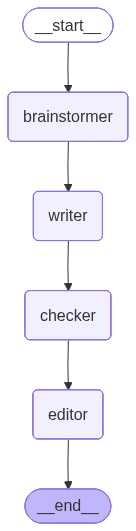

In [26]:
# Visualize
try:
    display(Image(collaborative_system.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → brainstormer → writer → checker → editor → END")

In [27]:
result = collaborative_system.invoke({
    "topic": "The Future of Remote Work",
    "messages": []
})

print("\n" + "="*70)
print("FINAL FORMATTED OUTPUT:")
print("="*70)
print(result["final_output"])
print("="*70)
print("\n📊 AGENT ACTIVITY:")
print("- Analyzer: Used extract_keywords tool")
print("- Researcher: Used search_knowledge_base tool")
print("- Formatter: Used format_as_summary tool")
print("="*70 + "\n")

   Key Ideas for The Future of Remote Work: 
1. Mental Health,
2. Innovation.
3. Income generation.


   BLOG DRAFT:
Intro: Welcome to the world of Key Ideas for The Future of Remote Work: 1. Mental Health: With the rise of remote work, there is a growing emphasis on the importance of mental health among employees. Companies will need to adopt practices that prioritize mental well-being, such as flexible work hours, mental health days, and access to counseling resources. Creating a supportive virtual environment can help reduce feelings of isolation and burnout, ensuring that employees remain engaged and productive.

2. Innovation: Remote work has the potential to foster innovation by allowing diverse teams from different geographic locations to collaborate seamlessly. As companies embrace remote work, they will need to invest in technology that facilitates effective communication and collaboration. This includes tools for brainstorming, project management, and virtual workshops that c